# American Express - Default Prediction
- 카드사 고객의 채무 불이행 여부 예측

## Data
- Features
  - D_* = 연체 변수 (96개)
  - S_* = 소비 변수 (22개)
  - P_* = 지불 변수 (3개)
  - B_* = 균형 변수 (40개)
  - R_* = 위험 변수 (28개)
  - Customer_ID 포함 총 190개
<br>
- 데이터 크기 
  - train : 5,531,451  - 고객에게 주어진 명세서 수와 같음
  - test : 11,363,762
- target
  - 총 458,913개(명) - 고객 수와 같음, 고객의 채무 불이행 여부
  - 1 (채무 불이행) : 118,828개
  - 0 (채무 정상 이행) : 340,085개
    - 실제 American Express 데이터는 690만 고객 중 10만 명만이 채무 불이행 고객일 정도로 불균형한 데이터이다. 여기서는 모델링을 쉽게 하기 위해 데이터를 균형있게 제공해준 것.
    - 그렇기 때문에 평가지표 계산 시에는 target이 0인 데이터는 20배의 가중치를 받는다.
  - 여기서 target은 고객이 최근 명세서 날짜 이후 120일 이내에 만기 금액을 지불하지 않았을 때 채무 불이행이라고 분류가 됨.
<br>
- 아래 feature들은 범주형 데이터이고, 그 이외는 수치형 데이터
  - ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
<br>
- 기간
  - train : 2017-03-01 ~ 2018-03-31 (396일)
  - test : 2018-04-01 ~ 2019-10-31 (579일)

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta
import plotly.graph_objects as go
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

## 설정

In [21]:
## 모든 열을 출력한다.
pd.set_option('display.max_columns', None) 

In [22]:
DATA_DIR = './data'

## Load pickle

In [23]:
# load pickle

with open("./pickles/df_train.pickle", "rb") as fr:
    df_train = pickle.load(fr)
with open("./pickles/df_test.pickle", "rb") as fr:
    df_test = pickle.load(fr)
with open("./pickles/df_train_target.pickle", "rb") as fr:
    df_train_target = pickle.load(fr)

- target value

In [ ]:
target1 = len(df_train_target[df_train_target["target"] == 1])
target0 = len(df_train_target[df_train_target["target"] == 0])

print(f"1 (채무 불이행) : {target1}")
print(f"0 (채무 정상 이행) : {target0}")

In [ ]:
target=df_train_target.target.value_counts(normalize=True)
target.rename(index={1:'Default',0:'Paid'},inplace=True)
colors = ['#17becf', '#E1396C']
data = go.Pie(
values= target,
labels= target.index,
marker=dict(colors=colors),
textinfo='label+percent'
)
layout = go.Layout( 
title=dict(text = "Target Distribution",x=0.46,y=0.95,font_size=20)
)
fig = go.Figure(data=data,layout=layout)
fig.show()

- df_train

In [ ]:
df_train.head()

In [ ]:
df_train["customer_ID"].nunique()

In [ ]:
df_train.info()

<AxesSubplot:>

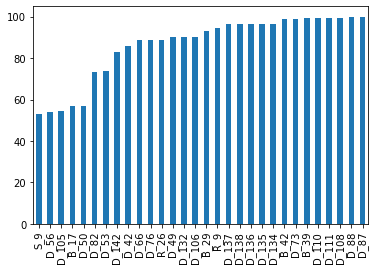

In [24]:
train_feat_null = df_train.isnull().sum() / len(df_train) * 100
train_feat_null[train_feat_null.values > 50].sort_values().plot.bar()

- categorical features

In [ ]:
df_train[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']].head()

In [25]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for feature in categorical:
  print(f"{feature} : {df_train[feature].unique()}")

B_30 : [ 0.  2.  1. nan]
B_38 : [ 2.  1.  3.  5.  6.  7.  4. nan]
D_114 : [ 1.  0. nan]
D_116 : [ 0. nan  1.]
D_117 : [ 4. -1.  6.  2.  1. nan  3.  5.]
D_120 : [ 0.  1. nan]
D_126 : [ 1. nan  0. -1.]
D_63 : ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 : ['O' 'R' nan 'U' '-1']
D_66 : [nan  1.  0.]
D_68 : [ 6.  2.  3. nan  5.  4.  0.  1.]


- 고객별 가장 최근 명세서에 대한 정보만 추림

In [26]:
df_train = pd.DataFrame(df_train.groupby(['customer_ID']).tail(1))
df_test = pd.DataFrame(df_test.groupby(['customer_ID']).tail(1))

In [ ]:
df_train.head()

---
# 여기서부터 작성
---

In [27]:
df_train_length = len(df_train) # 458913
df_test_length = len(df_test) # 924621

In [28]:
df_all = pd.concat([df_train, df_test], axis = 0).reset_index(drop = True)

In [ ]:
df_all.info()

- category 타입 변환

In [29]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for feature in categorical:
  print(f"{feature} : {df_train[feature].unique()}")

B_30 : [ 0.  1.  2. nan]
B_38 : [ 2.  1.  3.  7.  5.  6.  4. nan]
D_114 : [ 1.  0. nan]
D_116 : [ 0. nan  1.]
D_117 : [ 4. -1.  6.  1.  2.  5.  3. nan]
D_120 : [ 0.  1. nan]
D_126 : [1. 0.]
D_63 : ['CR' 'CO' 'CL' 'XL' 'XZ' 'XM']
D_64 : ['O' 'R' 'U' nan]
D_66 : [nan  1.]
D_68 : [ 6.  3.  5.  4.  2.  1. nan]


In [30]:
df_all[categorical] = df_all.loc[:, categorical].astype('category')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 190 entries, customer_ID to D_145
dtypes: category(11), float64(176), int64(1), object(2)
memory usage: 1.9+ GB


- CustomerID, S_2 삭제
  - 학습과 관련없는 column (고객 정보)

In [31]:
df_all = df_all.iloc[:, 2:]
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 188 entries, P_2 to D_145
dtypes: category(11), float64(176), int64(1)
memory usage: 1.8 GB


In [ ]:
df_all

<AxesSubplot:>

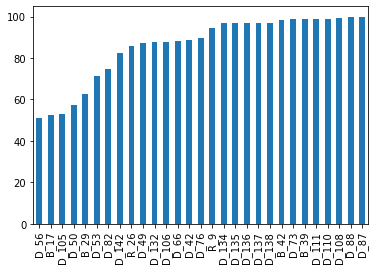

In [32]:
all_feat_null = df_all.isnull().sum() / len(df_all) * 100
all_feat_null[all_feat_null.values > 50].sort_values().plot.bar()

 - 70% 이상 결측치인 column은 drop

In [33]:
dropping_columns = all_feat_null[all_feat_null.values > 70].index.values
df_all = df_all.drop(dropping_columns, axis = 1)

In [60]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383534 entries, 0 to 1383533
Columns: 164 entries, P_2 to D_145
dtypes: category(10), float64(153), int64(1)
memory usage: 1.6 GB


- 결측치 확인

In [34]:
all_feat_null = df_all.isnull().sum() / len(df_all) * 100
all_feat_null = all_feat_null[all_feat_null != 0]
all_feat_null = all_feat_null.sort_values(ascending = False)
all_feat_null

B_29     62.757836
D_50     57.252153
D_105    53.222328
B_17     52.510961
D_56     51.170192
           ...    
B_30      0.005349
B_33      0.005349
B_27      0.005349
B_38      0.005349
B_26      0.005349
Length: 92, dtype: float64

In [51]:
D_columns = [col for col in all_feat_null.index if 'D_' in col]

In [52]:
len(D_columns)

57

<AxesSubplot:>

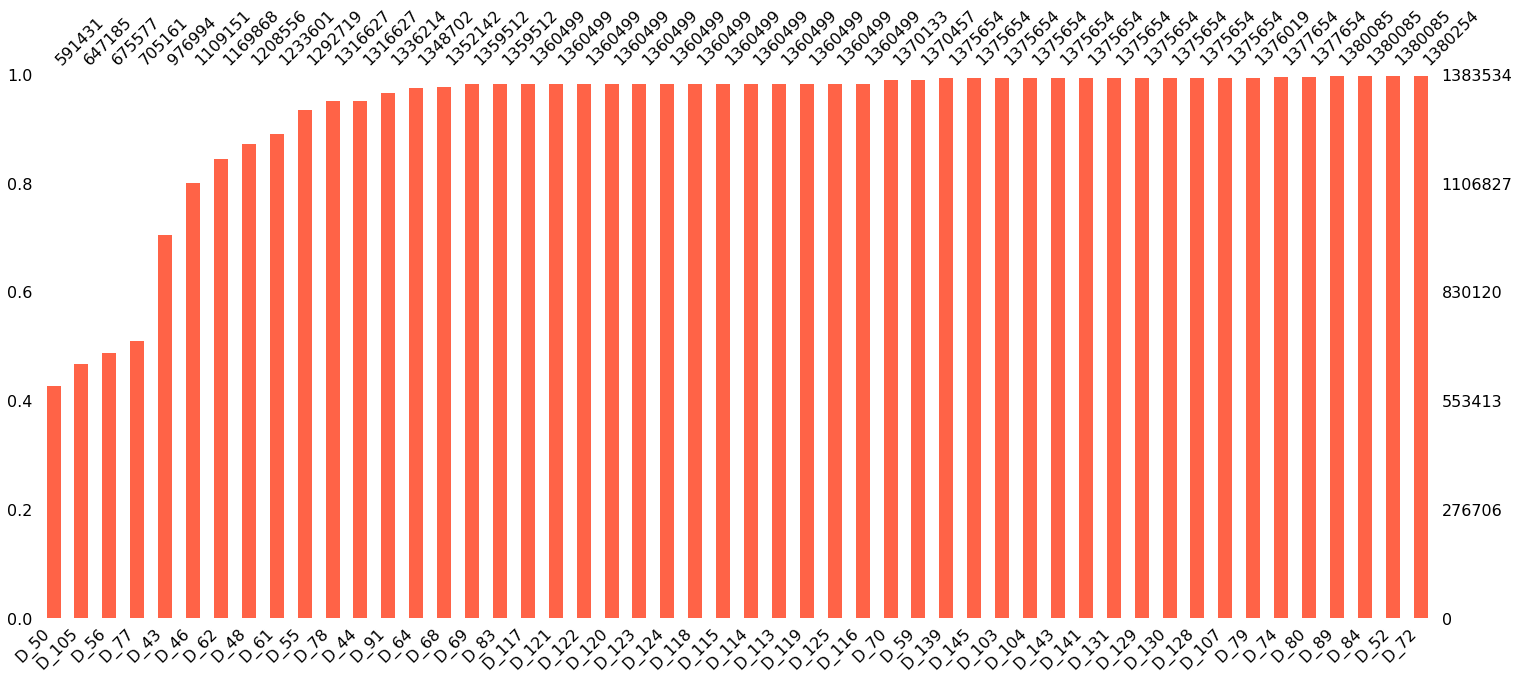

In [53]:
#plot of missing values
msno.bar(df_all[D_columns[:50]],figsize=(25,10),sort="ascending", color="tomato")

<AxesSubplot:>

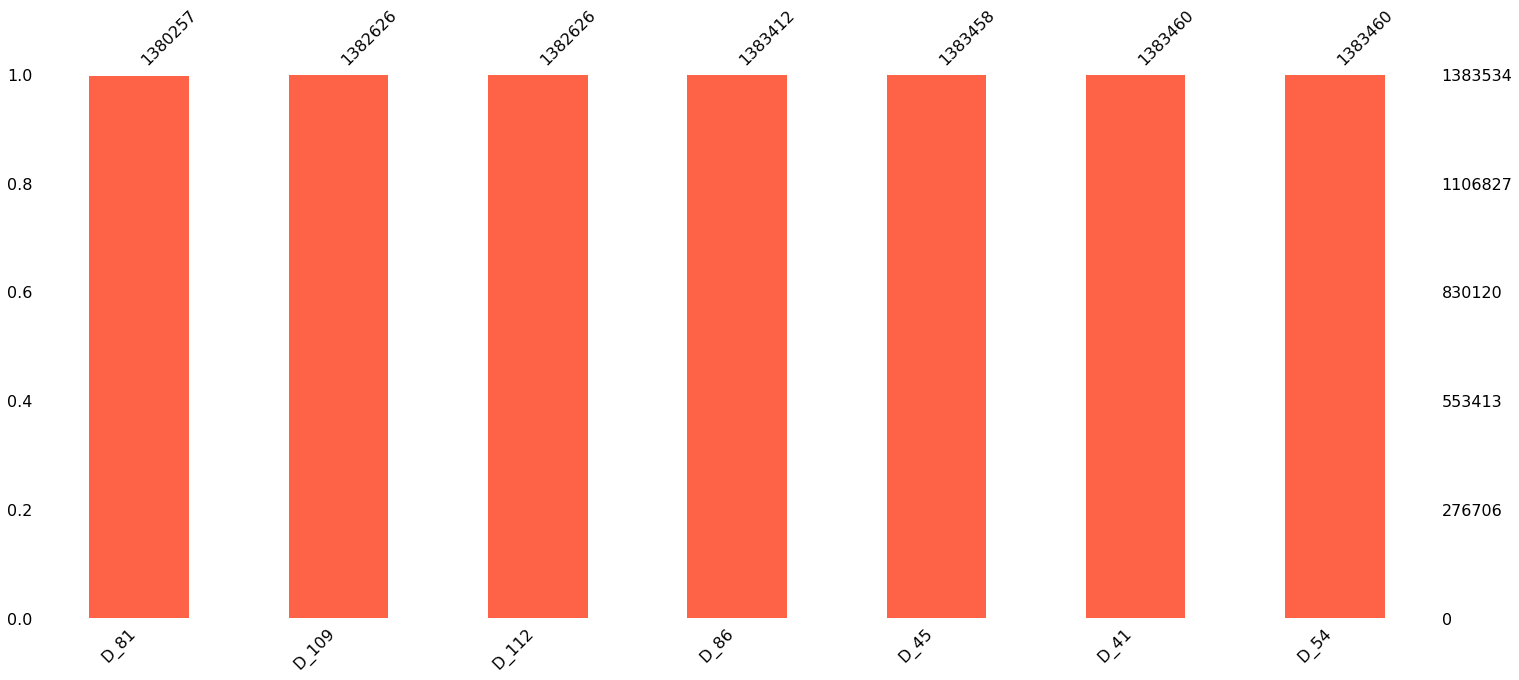

In [54]:
#plot of missing values
msno.bar(df_all[D_columns[50:]],figsize=(25,10),sort="ascending", color="tomato")

<AxesSubplot:>

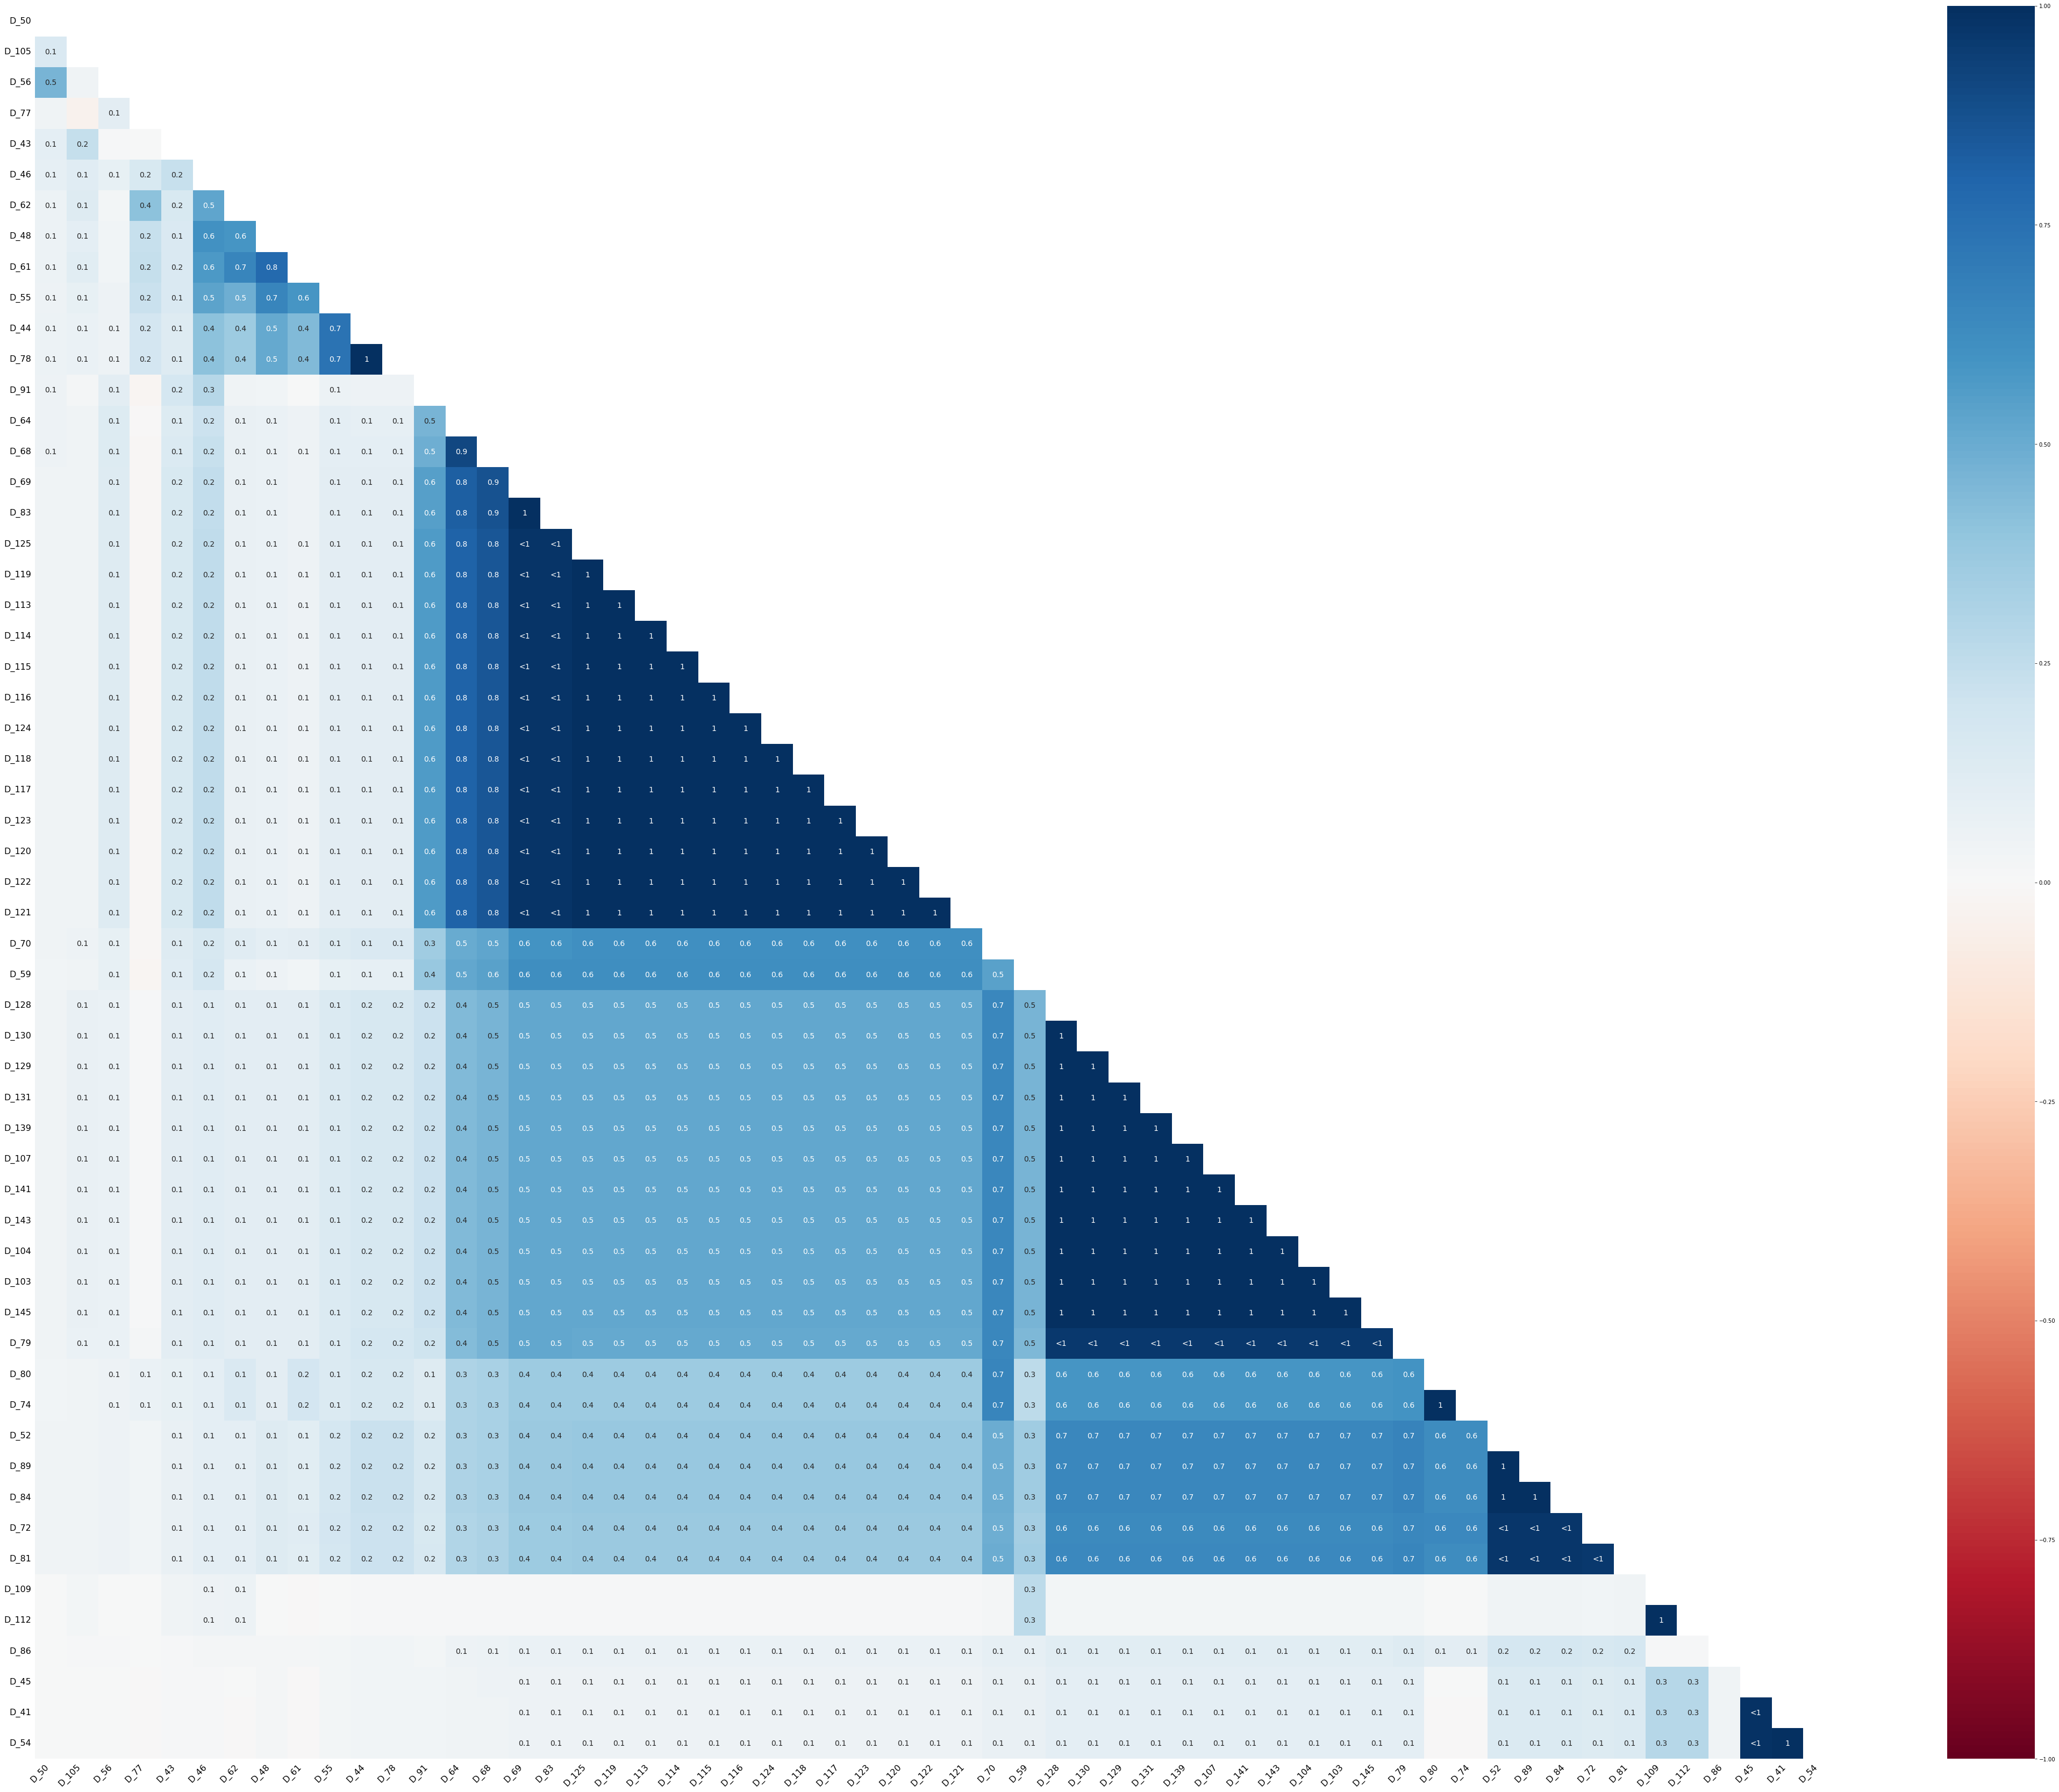

In [57]:
msno.heatmap(df_all[D_columns], figsize = (75, 60))

In [59]:
df_all[['D_119', 'D_125']].isnull().sum()

D_119    23035
D_125    23035
dtype: int64

---
# train, test 분리 후 학습
---

# Modeling 관련 라이브러리

In [35]:
from itertools import product

# Model
import xgboost as xgb 

# Feature selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Validation 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [50]:
# Build a DataFrame To Score the Performance

Performance_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Log Loss', 'ROC', 'Amex Metric'])
Performance_df

,Model,Accuracy,Log Loss,ROC,Amex Metric


In [40]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [41]:
def XGBoost_Randomize_CV(X,y, parameters, k = -1):
    
    # Create Parameter Combination
    keys, values = zip(*parameters.items())
    result = [dict(zip(keys, p)) for p in product(*values)]
    
    # If -1 Then Grid Search
    if k != -1:

        result = np.random.choice(result, k, replace = False)
        
    best_score = -1
    best_parameter = {}
    
    # Train Test Split
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for i in result:
        

        XGB_Model = xgb.XGBClassifier(**i,
                                      early_stopping_rounds = 10,
                                      verbosity = 0,
                                      enable_categorical = True,
                                      n_jobs = -1).fit(train_X, train_y, eval_set = [(test_X, test_y)], verbose=False)
        
        pred = XGB_Model.predict(test_X).round().astype(int)
        amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
        amex_prediction = pd.DataFrame({'prediction':XGB_Model.predict_proba(test_X)[:, 1]}).reset_index(drop=True)
        score = amex_metric(amex_actual,amex_prediction)
        
        if score > best_score:
            best_score = score
            best_parameter = i
            best_model = XGB_Model
        
        print(f'{i}: {score}')

        
    print(f'Best Parameters - {best_parameter}: {best_score}')
    
    return best_model

# 1. XGBoost - 1
- onehot 없음, smote 없음, 결측치 채우기 없음

In [ ]:
X = df_all[:df_train_length]
y = df_train_target["target"]

In [ ]:
X

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_107,B_36,B_37,R_27,B_38,D_109,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145
0,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,0.003258,0.070793,0.740102,0.231717,0.008309,0.420521,0.539715,0.192376,0.149564,0.058425,0.002927,0.153461,0.673522,0.009535,0.000085,0.203524,0.629392,0.326101,0.034643,0.010260,0.001770,1.008097,0.008517,0.105671,0.112294,0.488232,0.187285,0.166636,0.100107,0.009444,0.007174,0.007397,0.010239,0.063465,0.258461,0.227637,0.014553,0.402246,0.446568,CR,O,0.008656,0.006408,NaN,1.007897,0.005274,0.007630,6.0,0.184036,0.003945,0.686719,0.005375,0.005469,0.008050,0.008254,0.377991,0.006970,0.304625,0.040367,0.006564,0.001298,0.001352,0.002230,0.009162,0.421334,0.006475,0.001068,0.000747,0.002193,0.006345,0.000026,0.208253,0.001057,0.009351,0.007236,0.009177,0.006550,1.002178,0.084745,0.006099,0.000013,0.002902,0.001115,0.001911,0.003256,NaN,0.0,0.001277,0.009968,0.002330,0.002517,1,0.003511,0.008099,0.007645,0.009411,0.006355,0.008501,1.007528,0.004638,0.001445,0.003080,1.006011,0.003641,0.004638,0.003866,0.005909,0.005458,0.001190,0.917811,0.131801,0.936067,0.971994,0.001281,0.943340,1.002457,1.014510,1.073985,0.671683,0.007441,0.008676,1.006130,2.0,0.000226,1.009372,0.100454,0.928955,0.003658,1.0,0.255787,0.0,4.0,0.260255,0.256656,0.0,0.719791,0.433844,0.003580,0.684978,0.008398,1.0,1.008338,0.999737,1.008523,0.003973,0.004186,0.005702,0.006210,0.002715,0.007186,0.004234,0.005086,0.005810,0.002970,0.008533
1,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,0.060646,0.008781,0.020626,0.266275,0.027000,0.004976,0.438828,0.402195,0.014696,0.167634,0.028411,0.000974,NaN,0.339683,0.012926,0.102036,0.242366,0.570898,0.297130,0.043929,0.014570,0.002911,1.002821,0.003283,0.208516,0.019050,0.406434,0.036112,0.748383,0.017684,0.005880,0.009756,0.127805,0.018667,0.212538,0.411989,0.048978,0.009538,0.363754,0.233980,CO,O,0.008747,0.002940,NaN,1.003602,0.008047,0.004319,6.0,0.192371,0.007744,0.287101,0.006190,0.007636,0.006174,0.000883,0.007636,0.001278,0.304711,0.014705,0.004659,0.007925,0.009600,0.002383,0.008256,0.227755,0.021153,0.000182,0.001542,0.009117,0.006892,0.006931,0.002119,0.002046,0.009664,0.005375,0.005009,0.005414,1.008568,0.019672,0.006197,0.005370,0.006271,0.009911,0.000983,0.006669,NaN,0.0,0.009298,0.006460,0.006503,0.007052,1,0.005091,0.001838,0.008645,0.009467,0.003500,0.000473,1.000766,0.004864,0.000907,0.003830,0.009166,0.004641,0.000195,0.000523,0.006421,0.004975,0.002397,0.920889,0.132865,0.930629,0.977674,0.003213,0.001621,0.008952,0.004363,NaN,0.007774,0.007457,0.032899,1.007599,2.0,0.004743,1.006547,0.019811,0.292214,0.009312,1.0,0.454329,0.0,-1.0,0.446036,0.436884,0.0,0.551341,0.286821,0.008603,0.136650,0.009314,1.0,0.000229,0.999252,0.001777,0.002943,0.002202,0.001928,0.002996,0.001701,0.002980,0.007479,0.007870,0.003284,0.003169,0.008514
2,0.880875,0.009704,0.004284,0.812650,0.006450,NaN,0.003796,0.007196,NaN,0.000628,0.031044,0.251598,0.001557,0.001687,0.433713,0.339125,0.080370,0.183628,0.026981,0.000247,NaN,0.342118,0.009392,0.006264,0.202159,0.628938,0.296313,0.001824,0.005092,1.002365,1.005992,0.001983,NaN,0.007158,0.009188,0.098963,0.209386,0.001749,0.003000,0.002847,NaN,0.006699,0.213039,0.0028

In [ ]:
# Train Test Split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
random_parameters = {'max_depth':[9,10,11,12],
                      'min_child_weight': [5,6,7,8],
                      'eta':[.1, .01, .001],
                      'objective':['binary:logistic'],
                      'tree_method': ['gpu_hist'],
                      'eval_metric': ['rmsle'],
}

XGB_Best = XGBoost_Randomize_CV(train_X,train_y, random_parameters)

{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7638069823258702
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7562965804187952
{'max_depth': 9, 'min_child_weight': 5, 'eta': 0.001, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7327379960669427
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.1, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7687309449313934
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.01, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7542670130317026
{'max_depth': 9, 'min_child_weight': 6, 'eta': 0.001, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'eval_metric': 'rmsle'}: 0.7322089634213516
{'max_depth': 9, 'min_child_weight': 7, 'eta': 0.1, 'objective':

In [44]:
# Validation
pred = XGB_Best.predict(test_X).round().astype(int)
amex_actual = pd.DataFrame({'target':test_y}).reset_index(drop=True)
amex_prediction = pd.DataFrame({'prediction':XGB_Best.predict_proba(test_X)[:, 1]}).reset_index(drop=True)
Performance_df = Performance_df.append(pd.DataFrame([['XGBC', accuracy_score(test_y, pred), log_loss(test_y, pred), roc_auc_score(test_y, pred), amex_metric(amex_actual,amex_prediction)]],
                                                    columns = ['Model','Accuracy', 'Log Loss', 'ROC','Amex Metric']), sort = False)

print('Accuracy:', accuracy_score(test_y, pred))
print('Log Loss:', log_loss(test_y, pred))
print('ROC Accuracy:', roc_auc_score(test_y, pred))
print('Confusion Matrix:\n', 
       confusion_matrix(test_y, pred))
print('Amex Metric:', amex_metric(amex_actual,amex_prediction))

Accuracy: 0.8959934337638189
Log Loss: 3.592299905577403
ROC Accuracy: 0.8621813453529186
Confusion Matrix:
 [[95234  6951]
 [ 7368 28121]]
Amex Metric: 0.7672884779364937


In [49]:
Performance_df

,Model,Feature Selection,Accuracy,Log Loss,ROC,Amex Metric
0,XGBC,Full,0.895993,3.5923,0.862181,0.767288
